<a href="https://colab.research.google.com/github/Pranshav/online-mining/blob/master/Semi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Semihard triplet loss with KNN classificaton

importing the dataset

In [2]:
import numpy as np
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

x_train.shape

(60000, 28, 28, 1)

In [0]:
import tensorflow as tf
import tensorflow_addons as tfa

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))


the model

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(64, (5, 5), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),    
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(15), # No activation on final dense layer
    tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

model.compile(loss=tfa.losses.TripletSemiHardLoss(),
                      optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)              

In [18]:
train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.batch(32)

history = model.fit(
    train_dataset,
    epochs=20)

Epoch 1/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.4563
Epoch 2/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.3398
Epoch 3/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.3058
Epoch 4/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2830
Epoch 5/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2695
Epoch 6/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2589
Epoch 7/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2479
Epoch 8/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2432
Epoch 9/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2369
Epoch 10/20
1875/1875 [==============================] - 12s 7ms/step - loss: 0.2243
Epoch 11/20
1875/1875 [==============================] - 13s 7ms/step - loss: 0.2197
Epoch 12/20
1875/1875 [==============================] - 13s 7ms/step - lo

Classification using KNN

In [19]:
#the embeddings of size 128

X_train_trm = model.predict(train_dataset)
X_test_trm = model.predict(test_dataset)

X_test_trm.shape

(10000, 15)

the value of p is kept 1 as to obtain the manhattan distance from the minkowski metric, L1 norm is better for high dimensional embeddings 

In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn2 = KNeighborsClassifier(n_neighbors=24, p =1)
knn2.fit(X_train_trm,y_train)

from sklearn import metrics
y_pred = knn2.predict(X_test_trm)
km2 = metrics.accuracy_score(y_test, y_pred)
km2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


0.9101

Tsne plot

In [21]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

def scatter(x, labels, subtitle=None):
    palette = np.array(sns.color_palette("hls", 10))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.manifold import TSNE

tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(model.predict(x_test))
Xd = x_test.reshape(-1,784)
train_tsne_embeds1 = tsne.fit_transform(Xd)
Yd = y_test.reshape(y_test.shape[0],)

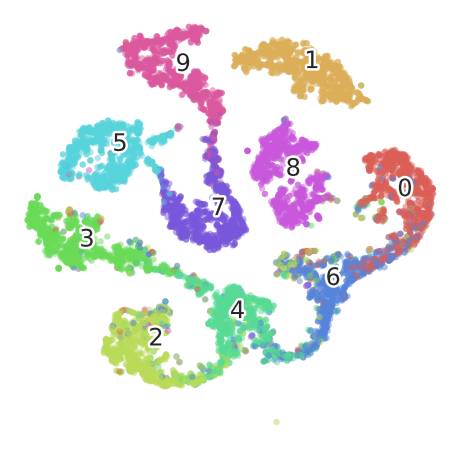

In [24]:
scatter(train_tsne_embeds,Yd)

In [0]:
def scatter1(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

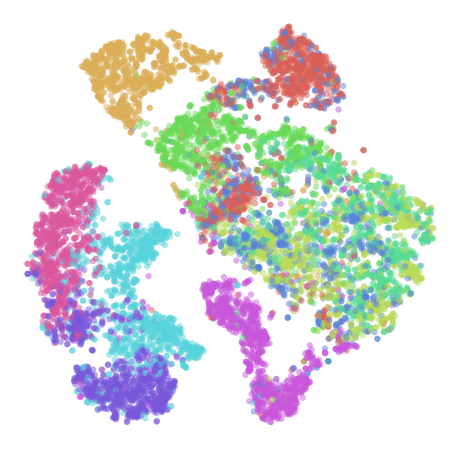

In [26]:
scatter1(train_tsne_embeds1,Yd)